<a href="https://colab.research.google.com/github/wedexyz/eeg-/blob/main/notesreduce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
pip install sklearn


In [146]:
import numpy as np
import tensorflow as tf
import keras
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM, BatchNormalization, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.optimizers import Adam
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,7)
import pandas as pd
import os
import random
import time
import os
from keras.callbacks import ModelCheckpoint, EarlyStopping
#from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

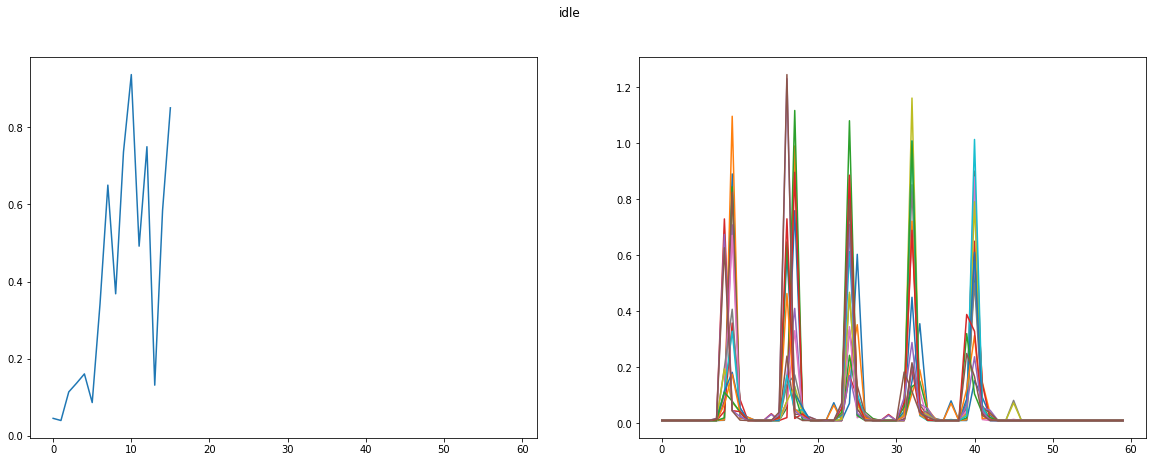

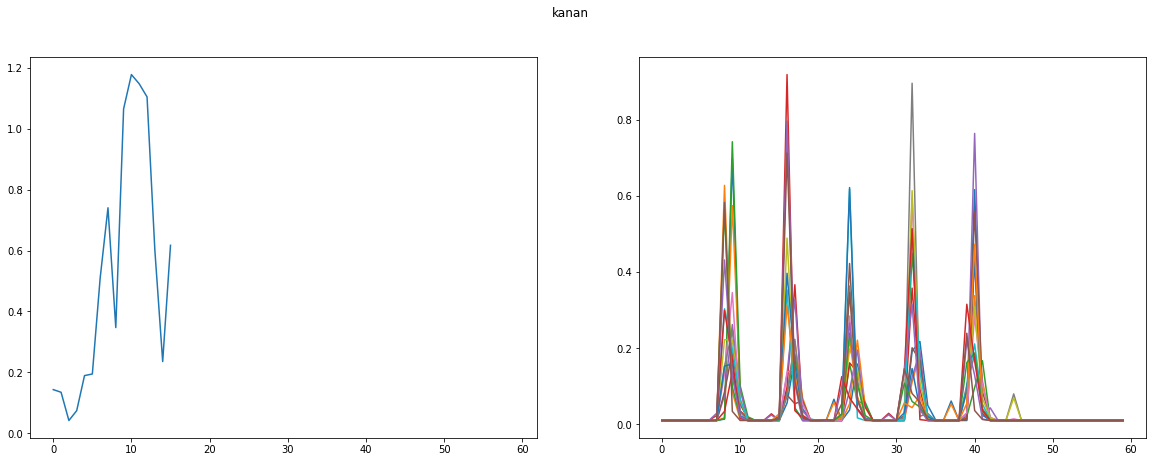

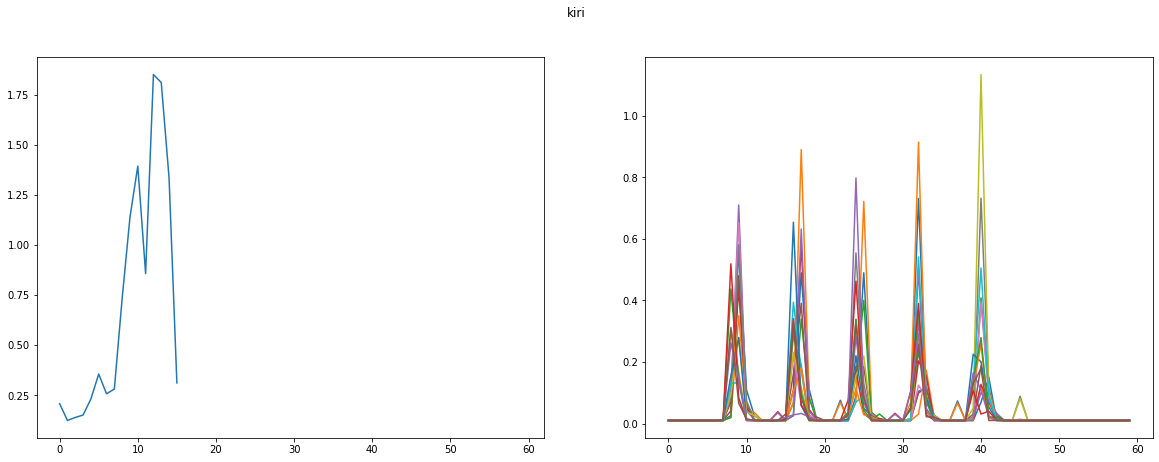

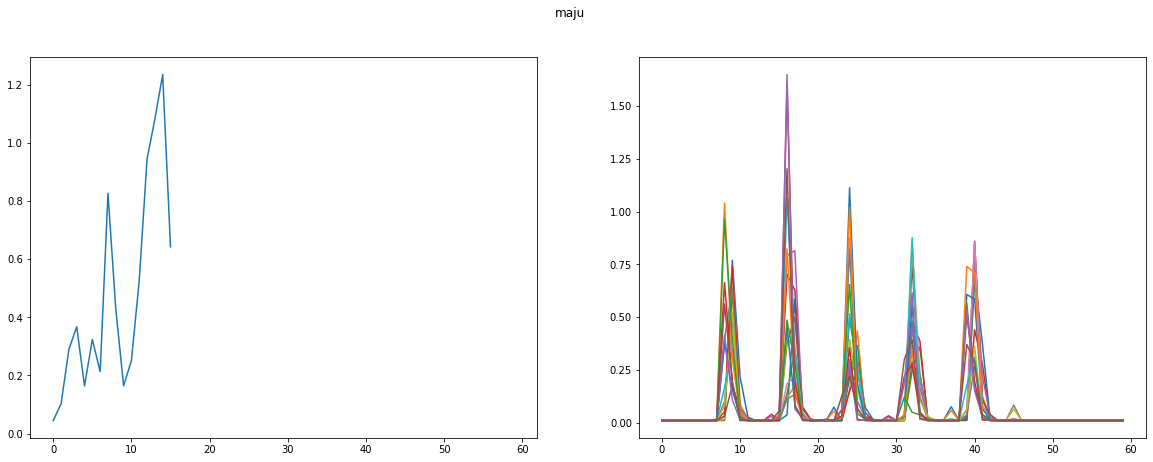

In [151]:
idle = np.load("/content/drive/My Drive/Colab Notebooks/data_baru/idle/1604315006.npy")
kanan = np.load("/content/drive/My Drive/Colab Notebooks/data_baru/kanan/1604315180.npy")
kiri = np.load("/content/drive/My Drive/Colab Notebooks/data_baru/kiri/1604315126.npy")
maju = np.load("/content/drive/My Drive/Colab Notebooks/data_baru/maju/1604315069.npy")

fig, (ax1, ax2) =  plt.subplots( ncols=2, sharex=True)
fig.suptitle('idle')
ax1.plot(idle[0][16])
ax2.plot(idle[175])

fig, (ax3, ax4) =  plt.subplots( ncols=2, sharex=True)
fig.suptitle('kanan')
ax3.plot(kanan[0][16])
ax4.plot(kanan[175])

fig, (ax5, ax6) =  plt.subplots( ncols=2, sharex=True)
fig.suptitle('kiri')
ax5.plot(kiri[0][16])
ax6.plot(kiri[175])

fig, (ax7, ax8) =  plt.subplots( ncols=2, sharex=True)
fig.suptitle('maju')
ax7.plot(maju[0][16])
ax8.plot(maju[175])



plt.show()

In [8]:
ACTIONS = ["kiri", "maju","idle","kanan"]
reshape = (-1,16, 60,1)
#reshape(-1,28,28,1)




In [9]:
def create_data(starting_dir="=/content/drive/My Drive/Colab Notebooks/data_baru"):
    training_data = {}
    for action in ACTIONS:
        if action not in training_data:
            training_data[action] = []
        data_dir = os.path.join(starting_dir,action)
        for item in os.listdir(data_dir):
            data = np.load(os.path.join(data_dir, item))
            for item in data:
                training_data[action].append(item)

    lengths = [len(training_data[action]) for action in ACTIONS]
    print(lengths)

    for action in ACTIONS:
        np.random.shuffle(training_data[action])  
        training_data[action] = training_data[action][:min(lengths)]

    lengths = [len(training_data[action]) for action in ACTIONS]
    print(lengths)
    combined_data = []
    for action in ACTIONS:
        for data in training_data[action]:
            if action == "kiri":
                combined_data.append([data, [1, 0, 0,0]])
            elif action == "maju":
                combined_data.append([data, [0, 1, 0, 0]])
            elif action == "idle":
                combined_data.append([data, [0, 0, 1, 0]])
            elif action == "kanan":
                combined_data.append([data, [0, 0, 0, 1]])

    np.random.shuffle(combined_data)
    print("length:",len(combined_data))
    return combined_data

In [10]:
print("creating training data")
traindata = create_data(starting_dir="/content/drive/My Drive/Colab Notebooks/data_baru")
train_X = []
train_y = []
for X, y in traindata:
    train_X.append(X)
    train_y.append(y)



creating training data
[1000, 1000, 1000, 1000]
[1000, 1000, 1000, 1000]
length: 4000


In [11]:
print("creating testing data")
testdata = create_data(starting_dir="/content/drive/MyDrive/Colab Notebooks/tes_data")
test_X = []
test_y = []

for X, y in testdata:
    test_X.append(X)
    test_y.append(y)
train_X = np.array(train_X).reshape(reshape)
test_X = np.array(test_X).reshape(reshape)

train_y = np.array(train_y)
test_y = np.array(test_y)



creating testing data
[250, 250, 250, 250]
[250, 250, 250, 250]
length: 1000


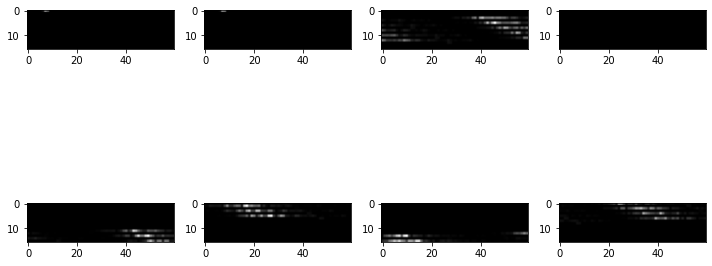

In [13]:
f, ax = plt.subplots(2,4) 
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(4):
       # ax[i,j].imshow(train_X [k].reshape(28, 28) , cmap = "gray")
        ax[i,j].imshow(train_X [k].reshape(16,60)  ,cmap = "gray")
        k += 1
    plt.tight_layout()    

In [81]:
IMAGE_SIZE = (16, 60, 1)

In [111]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(train_X)

In [112]:
learning_rate_reduction = ReduceLROnPlateau(monitor='accuracy', patience = 5, verbose=1,factor=0.5, min_lr=0.0001)

In [113]:
def cnn_model(size, num_cnn_layers):
    
    NUM_FILTERS = 64
    KERNEL = (7, 7)
    #MIN_NEURONS = 20
    #MAX_NEURONS = 120

    model = Sequential()
    '''
    for i in range(1, num_cnn_layers+1):
        if i == 1:
            model.add(Conv2D(NUM_FILTERS*i, KERNEL, input_shape=train_X.shape[1:], activation='relu', padding='same'),)
        else:
            model.add(Conv2D(NUM_FILTERS*i, KERNEL, activation='relu', padding='same'))
    
    #model = Sequential()
    '''
    model.add(Conv2D(filters = 64, kernel_size = (7,7), padding = "same", activation = "relu", input_shape=train_X.shape[1:]))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 64, kernel_size = (5,5), padding = "same", activation = "relu",input_shape=train_X.shape[1:]))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (5,5)))
    model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = "same", activation = "relu",input_shape=train_X.shape[1:]))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (3,3)))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(32, activation = "relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(4, activation = "sigmoid"))
    model.compile(optimizer ="adam", loss = "binary_crossentropy", metrics = ['accuracy'])
    #adam = Adam(lr = 0.001)
    
    #model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    #print(model.summary())
    
    return model


In [114]:
model = cnn_model(IMAGE_SIZE, 2)

In [115]:
model.summary()

Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_240 (Conv2D)          (None, 16, 60, 64)        3200      
_________________________________________________________________
batch_normalization_192 (Bat (None, 16, 60, 64)        256       
_________________________________________________________________
conv2d_241 (Conv2D)          (None, 16, 60, 64)        102464    
_________________________________________________________________
batch_normalization_193 (Bat (None, 16, 60, 64)        256       
_________________________________________________________________
max_pooling2d_96 (MaxPooling (None, 3, 12, 64)         0         
_________________________________________________________________
conv2d_242 (Conv2D)          (None, 3, 12, 64)         36928     
_________________________________________________________________
batch_normalization_194 (Bat (None, 3, 12, 64)       

In [116]:
#set early stopping criteria
pat = 5
#this is the number of epochs with no improvment after which the training will stop
early_stopping = EarlyStopping(monitor='loss', patience=pat, verbose=1)

#define the model checkpoint callback -> this will keep on saving the model as a physical file
model_checkpoint = ModelCheckpoint('fas_mnist_1.h5', verbose=1, save_best_only=True)

#define a function to fit the model
def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS=100, BATCH_SIZE=16):
    model = None
    model = cnn_model(IMAGE_SIZE, 2)
    #Model = model
   # results = model.fit(t_x, t_y, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping, model_checkpoint], 
   #           verbose=1, validation_split=0.1) 
    results = model.fit(t_x, t_y, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[learning_rate_reduction,early_stopping, model_checkpoint], 
              verbose=1, validation_split=0.1)   
    print("Val Score: ", model.evaluate(val_x, val_y))
    return results

In [117]:
n_folds=5
epochs=100
batch_size=16

#save the model history in a list after fitting so that we can plot later
model_history = [] 

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    t_x, val_x, t_y, val_y = train_test_split(train_X, train_y, test_size=0.1, 
                                               random_state = np.random.randint(1,1000, 1)[0])
    model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size))
   
    print("======="*12, end="\n\n\n")


Training on Fold:  1
Epoch 1/100
198/203 [============================>.] - ETA: 0s - loss: 0.7448 - accuracy: 0.2557
Epoch 00001: val_loss improved from inf to 0.61327, saving model to fas_mnist_1.h5
203/203 [==============================] - 1s 6ms/step - loss: 0.7423 - accuracy: 0.2565 - val_loss: 0.6133 - val_accuracy: 0.2472
Epoch 2/100
196/203 [===========================>..] - ETA: 0s - loss: 0.6254 - accuracy: 0.2695
Epoch 00002: val_loss improved from 0.61327 to 0.58663, saving model to fas_mnist_1.h5
203/203 [==============================] - 1s 5ms/step - loss: 0.6252 - accuracy: 0.2673 - val_loss: 0.5866 - val_accuracy: 0.2444
Epoch 3/100
197/203 [============================>.] - ETA: 0s - loss: 0.5970 - accuracy: 0.2598
Epoch 00003: val_loss improved from 0.58663 to 0.56133, saving model to fas_mnist_1.h5
203/203 [==============================] - 1s 5ms/step - loss: 0.5974 - accuracy: 0.2586 - val_loss: 0.5613 - val_accuracy: 0.2944
Epoch 4/100
199/203 [=================

In [122]:
#Load the model that was saved by ModelCheckpoint
model = load_model('fas_mnist_1.h5')

In [125]:
#model.evaluate(test_X, test_y)
print("Accuracy of the model is - " , model.evaluate(test_X,test_y)[1]*100 , "%")

32/32 [==============================] - 0s 4ms/step - loss: 0.1423 - accuracy: 0.8320
Accuracy of the model is -  83.20000171661377 %


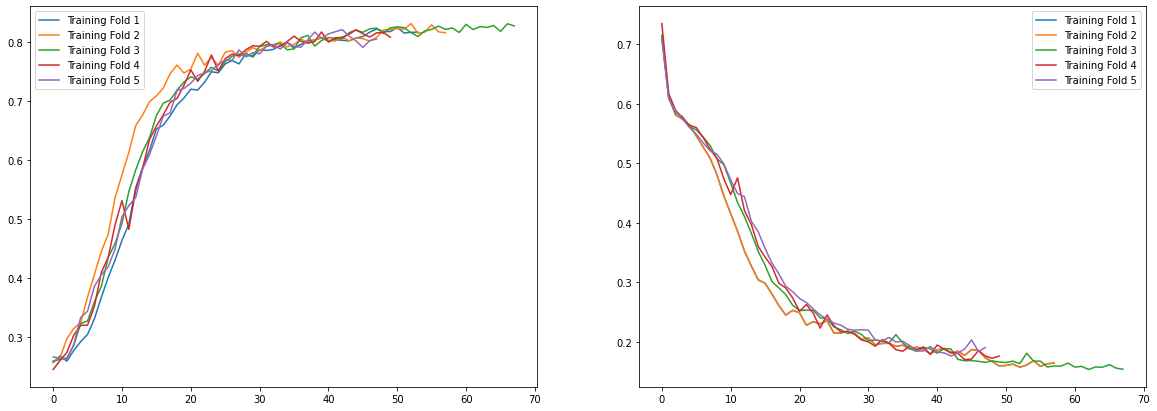

In [154]:
fig, (ax1, ax2) =  plt.subplots( ncols=2, sharex=True)
#ax1.title('Accuracies vs Epochs')
ax1.plot(model_history[0].history['accuracy'], label='Training Fold 1')
ax1.plot(model_history[1].history['accuracy'], label='Training Fold 2')
ax1.plot(model_history[2].history['accuracy'], label='Training Fold 3')
ax1.plot(model_history[3].history['accuracy'], label='Training Fold 4')
ax1.plot(model_history[4].history['accuracy'], label='Training Fold 5')
ax1.legend()
ax2.plot(model_history[1].history['loss'], label='Training Fold 1')
ax2.plot(model_history[1].history['loss'], label='Training Fold 2')
ax2.plot(model_history[2].history['loss'], label='Training Fold 3')
ax2.plot(model_history[3].history['loss'], label='Training Fold 4')
ax2.plot(model_history[4].history['loss'], label='Training Fold 5')
ax2.legend()
plt.show()

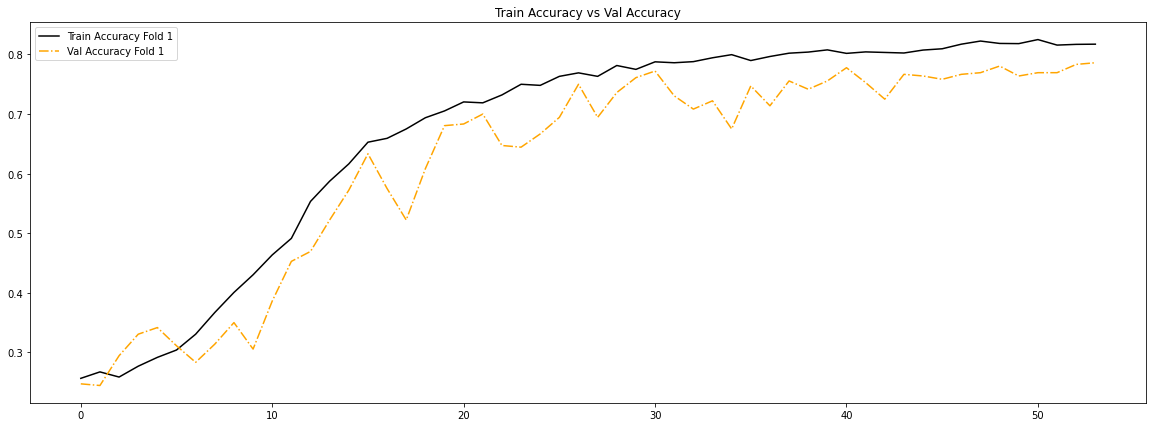

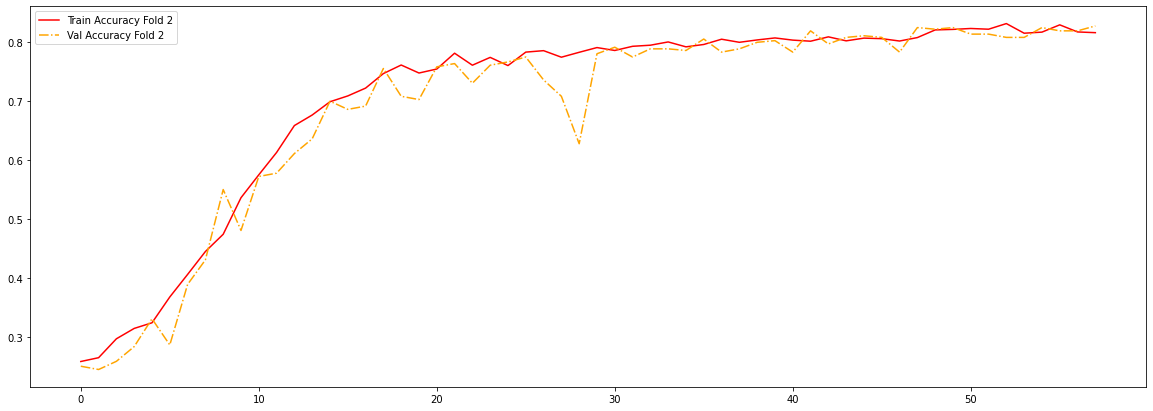

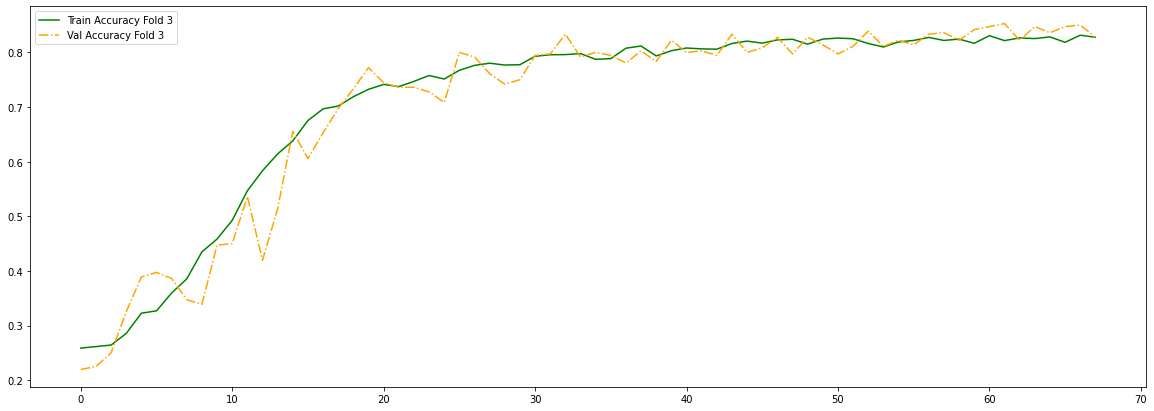

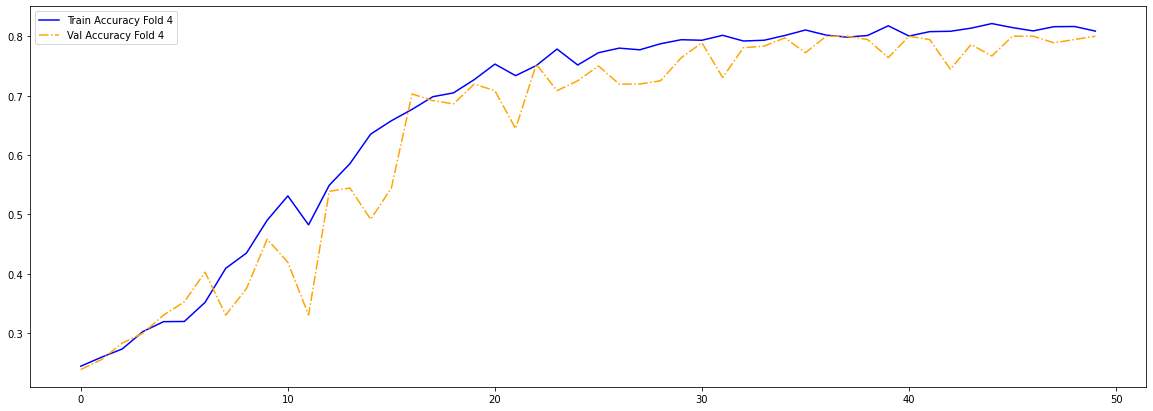

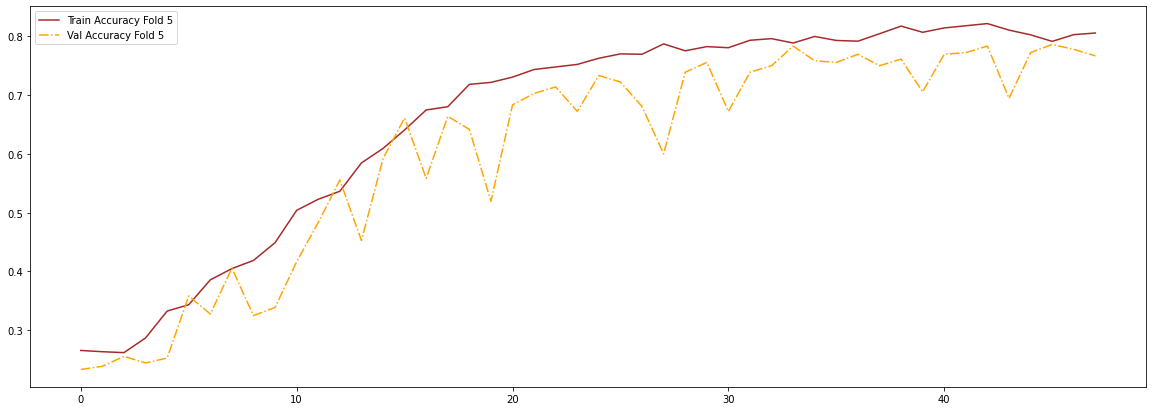

In [156]:
plt.title('Train Accuracy vs Val Accuracy')
plt.plot(model_history[0].history['accuracy'], label='Train Accuracy Fold 1', color='black')
plt.plot(model_history[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='orange', linestyle = "dashdot")
plt.legend()
plt.show()
plt.plot(model_history[1].history['accuracy'], label='Train Accuracy Fold 2', color='red', )
plt.plot(model_history[1].history['val_accuracy'], label='Val Accuracy Fold 2', color='orange', linestyle = "dashdot")
plt.legend()
plt.show()
plt.plot(model_history[2].history['accuracy'], label='Train Accuracy Fold 3', color='green', )
plt.plot(model_history[2].history['val_accuracy'], label='Val Accuracy Fold 3', color='orange', linestyle = "dashdot")
plt.legend()
plt.show()
plt.plot(model_history[3].history['accuracy'], label='Train Accuracy Fold 4', color='blue', )
plt.plot(model_history[3].history['val_accuracy'], label='Val Accuracy Fold 4', color='orange', linestyle = "dashdot")
plt.legend()
plt.show()
plt.plot(model_history[4].history['accuracy'], label='Train Accuracy Fold 5', color='brown', )
plt.plot(model_history[4].history['val_accuracy'], label='Val Accuracy Fold 5', color='orange', linestyle = "dashdot")

plt.legend()
plt.show()

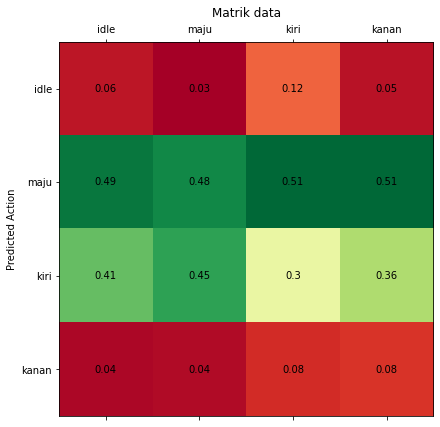

In [175]:

MODEL_NAME ='/content/fas_mnist_1.h5' 
CLIP = True  # if your model was trained with np.clip to clip  values
CLIP_VAL = 10  # if above, what was the value +/-

model = tf.keras.models.load_model(MODEL_NAME)

VALDIR = "/content/drive/MyDrive/Colab Notebooks/tes_data"
ACTIONS =  ["idle","maju","kiri", "kanan"]
PRED_BATCH = 16


def get_val_data(valdir, action, batch_size):

    argmax_dict = {0: 0, 1: 0, 2: 0,3:0}
    raw_pred_dict = {0: 0, 1: 0, 2: 0,3:0}

    action_dir = os.path.join(valdir, action)
    for session_file in os.listdir(action_dir):
        filepath = os.path.join(action_dir,session_file)
        if CLIP:
            data = np.clip(np.load(filepath), -CLIP_VAL, CLIP_VAL) / CLIP_VAL
        else:
            data = np.load(filepath) 
        preds = model.predict([data.reshape(-1, 16, 60,1)], batch_size=batch_size)

        for pred in preds:
            argmax = np.argmax(pred)
            argmax_dict[argmax] += 1
            for idx,value in enumerate(pred):
                raw_pred_dict[idx] += value

    argmax_pct_dict = {}
    for i in argmax_dict:
        total = 0
        correct = argmax_dict[i]
        for ii in argmax_dict:
            total += argmax_dict[ii]
        argmax_pct_dict[i] = round(correct/total, 4)
    return argmax_dict, raw_pred_dict, argmax_pct_dict


def make_conf_mat(none,left,forward,  right):
    action_dict = {"idle":none,"maju": forward, "kiri": left, "kanan": right}
    action_conf_mat = pd.DataFrame(action_dict)
    actions = [i for i in action_dict]

    fig = plt.figure(figsize=(15, 6))
   
    ax = fig.add_subplot(111)
    
    ax.matshow(action_conf_mat, cmap=plt.cm.RdYlGn)
    ax.set_xticklabels([""]+actions)
    ax.set_yticklabels([""]+actions)

    #print("__________")
    #print(action_dict)
    for idx, i in enumerate(action_dict):
        #print('tf',i)
        for idx2, ii in enumerate(action_dict[i]):
            #print(i, ii)
            #print(action_dict[i][ii])
            ax.text(idx, idx2, f"{round(float(action_dict[i][ii]),2)}", va='center', ha='center')
    # Rotate the tick labels and set their alignment.
    
    plt.title("Matrik data")
    plt.ylabel("Predicted Action")
    fig.tight_layout()
    plt.show()


left_argmax_dict, left_raw_pred_dict, left_argmax_pct_dict = get_val_data(VALDIR, "kiri", PRED_BATCH)
forward_argmax_dict, forward_raw_pred_dict, forward_argmax_pct_dict = get_val_data(VALDIR, "maju", PRED_BATCH)
none_argmax_dict, none_raw_pred_dict, none_argmax_pct_dict = get_val_data(VALDIR, "idle", PRED_BATCH)
right_argmax_dict, right_raw_pred_dict, right_argmax_pct_dict = get_val_data(VALDIR, "kanan", PRED_BATCH)
make_conf_mat(none_argmax_pct_dict,forward_argmax_pct_dict, left_argmax_pct_dict, right_argmax_pct_dict)

